### 第8天：TensorFlow2构建数据管道—Pandas DataFrame格式


**涉及到的知识点：**

 + 特征列的处理

 + 类别不均衡样本的处理
 
 + 自定义成本、评估函数

### <font color=#0099ff size=4 face="微软雅黑">实例：心脏病患者诊断</font>

数据集说明：
+ 该文件有303行，一行表示一个病人的特征数据；
+ 每个病人有14个特征，其中13个数据特征，分别是：age、sex、cp、trestbps、chol、fbs、restecg、thalach、exang、oldpeak、slope、ca、thal；1个目标特征target；
+ 特征说明

    + **连续数据特征**
      + age（年龄）
      + trestbps（静息血压）
      + chol（血清类固醇）
      + thalach（最大心率）
      + oldpeak（运动诱导的ST段下降）
      + ca（荧光透视法染色的大血管动脉的数量）

    + **离散数据特征**
      + sex（性别）： 1--男；0--女；
      + cp（胸部疼痛的类型）：0；1；2；3；4；
      + fbs（空腹血糖）：1--大于120mg/dl；0--不大于120mg/dl；
      + restecg（静息心电图结果）：0--正常；1--有ST-T波异常；2--左心室肥厚；
      + exang（运动诱发心绞痛）：1--是；0--否；
      + slope（运动高峰期的ST段斜率）：1--上斜；2--水平；
      + thal（地中海贫血基因）：normal--正常；fixed--固有缺陷； reversible--可修复缺陷；

    + **目标特征**
      + **target—心脏病**：0--未患病；1--患病；

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS' 
plt.rcParams['axes.unicode_minus']=False
from tensorflow import feature_column
import os
from sklearn.metrics import roc_curve
import seaborn as sns
print('tensorflow版本：', tf.__version__)

tensorflow版本： 2.1.0


### 1、数据获取

In [2]:
# 这个数据集的网址
Data_Url_Heart = 'https://storage.googleapis.com/applied-dl/heart.csv'
# 文件下载到给定的路径
Path_Heart = tf.keras.utils.get_file(r'C:\tf\heart.csv', Data_Url_Heart)

16384/13273 [=====================================] - 0s 4us/step


### 2、Pandas DataFrame格式

In [3]:
# Pandas 的DataFrame格式
df_data = pd.read_csv(Path_Heart)
df_data.head(n=3) 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0


### 3、数据预处理

#### 3.1 缺失值

In [4]:
# 判断是否缺失值
df_data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

#### 3.2 异常值

In [5]:
# thal列中有一个值为1和值为2的，判定为异常值，在数据中删除这2条数据
a1 = list(df_data[df_data['thal'].values == '1'].index.values)
a2 = list(df_data[df_data['thal'].values == '2'].index.values)
del_df_data = df_data.drop(a1 + a2)

#### 3.3  更改数据类型

根据特征表示的意义更改相应列的数据类型。

In [6]:
for k in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']:
    del_df_data[k] = ['%s' % f for f in del_df_data[k].values]
    

In [7]:
# 查看数据类型
del_df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       301 non-null    int64  
 1   sex       301 non-null    object 
 2   cp        301 non-null    object 
 3   trestbps  301 non-null    int64  
 4   chol      301 non-null    int64  
 5   fbs       301 non-null    object 
 6   restecg   301 non-null    object 
 7   thalach   301 non-null    int64  
 8   exang     301 non-null    object 
 9   oldpeak   301 non-null    float64
 10  slope     301 non-null    object 
 11  ca        301 non-null    int64  
 12  thal      301 non-null    object 
 13  target    301 non-null    int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 35.3+ KB


### 4、构建数据管道

对于分类问题首先要查看数据集中各个类别占的比例。

In [8]:
def judge(dataset, name='target'):
    str_s = ''
    data_v = dataset[name].unique()
    cvalues = dataset[name].values
    for ji in data_v:
        str_s += '%s:%3d  ' % (ji, list(cvalues).count(ji))
    return str_s
print(judge(del_df_data))

0:218  1: 83  


因为本数据集类别不均衡，因此分割数据集时尽量保证每个数据集中的类别比例相近。

In [9]:
# 分割数据集:split_p列表形式，第一个为验证数据集的比例，第二个为测试数据集的比例，
# 有第二个比例，数据集分成训练、验证、测试，没有的话分割为训练和验证(测试)
def split_data(data, split_p=[0.16, 0.14], name='target'):
    class_value = data[name].unique()
    dict_data = {}
    for c in class_value:
        dict_data[c] = {}
        data_c = data[data[name]==c].copy()
        # 获取索引号
        index_list = list(data_c.index)
        # 随机打乱数据
        np.random.shuffle(index_list)
        start_n = 0
        split_cp = split_p + [1-sum(split_p)]
        for kk, value in enumerate(split_cp):
            if kk != len(split_p):
                count = int(len(data_c) * value)
                # 行号
                hang = index_list[start_n:(start_n + count)]
                start_n += count
            else:
                hang = index_list[start_n:]
            dict_data[c][kk] = data_c.loc[hang]
 
    # 分割的数据集，不同类的集成在一起
    cc = []
    for kkd in range(len(split_p), -1, -1):
        data_f = pd.DataFrame()
        for ke in dict_data:
            data_f = pd.concat([data_f, dict_data[ke][kkd]],axis=0)
        cc.append(data_f)
    
    if len(split_p) == 1:
        train, val = cc
        return train, val
    elif len(split_p) == 2:
        train, test, val= cc
        return train, test, val
    else:
        return cc
      
train, test, val = split_data(del_df_data)

print('训练数据 条数:%3d' % len(train), '其中%s' % (judge(train)))
print('验证数据 条数:%3d' % len(val), '其中%s' % (judge(val)))
print('测试数据 条数:%3d' % len(test), '其中%s' % (judge(test)))

训练数据 条数:213 其中0:154  1: 59  
验证数据 条数: 47 其中0: 34  1: 13  
测试数据 条数: 41 其中0: 30  1: 11  


Pandas DataFrame格式的数据利用tf.data转变为数据管道的形式。

In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32, name='target'):
    dataframe = dataframe.copy()
    labels = dataframe.pop(name)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

训练、验证、测试数据集分别转变为数据管道的形式，注意训练数据需要打乱顺序。

In [11]:
batch_size = 6 # 这个数设置的较小，主要是为了后面进行特征列的处理时，展示方便
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

### 5、特征列处理

   如果建立的是基于树的模型，不进行特征列处理也是可以的，因为树模型是能够处理离散变量和连续变量特征的。如果建立的是非树模型，则必须对字符串形式的特征以及离散特征进行处理。本文建立的是MLP模型，因此需要进行特征列的处理。
   
   下面展示不同列的处理方式，并展示处理前后数据变化的对比。

In [12]:
# 使用数据通道中的第一批数据来演示处理列的不同方式
example_batch = next(iter(train_ds))[0]
#  将处理后的列的结果展示出来
def demo(feature_column):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

### 5.1 离散特征
列值表示类别，通常的处理方式是独热化编码，对于类别较多的情况，独热化编码会导致列过多，此时可以使用嵌入列或者哈希列。例子：thal、sex、cp、fbs、restecg、exang、slope

**（1）独热编码：特征thal**

就是将特征列中的不重复的值的个数作为向量的长度，向量的元素均为0。也就是每个类别都对应这个向量中的一个位置。如果某样本数据中该特征的类别为c，则向量中对应类别c的位置的数字变为1，其他的依然是0。具体看下面示例：

In [13]:
# 原始数据
example_batch['thal'].numpy()

array([b'reversible', b'normal', b'normal', b'normal', b'reversible',
       b'normal'], dtype=object)

In [58]:
# 独热编码后的数据
thal = feature_column.categorical_column_with_vocabulary_list('thal', ['fixed', 'normal', 'reversible'])
thal_one_hot = feature_column.indicator_column(thal)
demo(thal_one_hot)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


**（2）嵌入列：特征cp**

也就是用长度更少的向量来描述不同的类别。例如下面例子中，若用独热编码，则类别对应的向量长度需要为5，而采用嵌入列，长度为2即可。注意嵌入列的结果每次运行都会变化。

In [15]:
# 原始数据
example_batch['cp'].numpy()

array([b'3', b'4', b'3', b'3', b'4', b'3'], dtype=object)

In [16]:
#  嵌入列后的数据
cp = feature_column.categorical_column_with_vocabulary_list('cp', ['0', '1', '2', '3', '4'])
cp_embedding = feature_column.embedding_column(cp, dimension=2)  # dimension属于可调节的参数
demo(cp_embedding)

[[-0.4458764   0.13114235]
 [-0.18212312 -0.4205882 ]
 [-0.4458764   0.13114235]
 [-0.4458764   0.13114235]
 [-0.18212312 -0.4205882 ]
 [-0.4458764   0.13114235]]


**（3）哈希列：特征cp**

会导致不同的类别映射的结果是一样的。

In [17]:
# 原始数据
example_batch['cp']

<tf.Tensor: shape=(6,), dtype=string, numpy=array([b'3', b'4', b'3', b'3', b'4', b'3'], dtype=object)>

In [59]:
# 经过哈希处理后的数据
cp_hashed = feature_column.categorical_column_with_hash_bucket('cp', hash_bucket_size=3)
demo(feature_column.indicator_column(cp_hashed))

[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


### 5.2 连续特征

列值表示量，通常的处理方式有标准化、归一化、分桶，前面2种变换后依然是连续变量，分桶就是将连续特征变为独热化的类别特征。例子：age、trestbps、chol、thalach、ca、oldpeak等。如果对于某列而言，如果不同的量的个数较少，也可以视为类别，例如ca。

**（1）分桶：特征age**

对于连续的变量，根据给定的多个边界值，将原来的连读数值对应到相应的类别中，返回的是独热化后的数据。

In [19]:
# 原始数据
age = feature_column.numeric_column('age')
demo(age)

[[62.]
 [63.]
 [53.]
 [39.]
 [50.]
 [67.]]


In [20]:
# 分桶后的数据
age_buckets = feature_column.bucketized_column(age, boundaries=[20, 30, 40, 50, 60, 70])
demo(age_buckets)

[[0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


**（2）归一化：特征oldpeak**

将数据归一化到[0, 1]之间，这个区间可以自定义。

In [21]:
# 原始数据
example_batch['oldpeak']


<tf.Tensor: shape=(6,), dtype=float32, numpy=array([1.2, 1.8, 1.2, 0. , 2.6, 0. ], dtype=float32)>

In [22]:
# 数据归一化
oldpeak = feature_column.numeric_column('oldpeak', normalizer_fn=lambda x: x / 5.6)
demo(oldpeak)

[[0.21428573]
 [0.32142857]
 [0.21428573]
 [0.        ]
 [0.4642857 ]
 [0.        ]]


### 6、特征选择

In [23]:
# 进行独热化的离散特征
CATEGORICAL_COLUMNS_ONEHOT = ['sex', 'fbs', 'restecg', 'exang', 'slope', 'thal']
# 进行嵌入列的离散特征
CATEGORICAL_COLUMNS_EMBED = ['cp']
# 归一化特征
NUMERIC_COLUMNS_NORM = ['trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
# 分通化特征
NUMERIC_COLUMNS_BUCKET = ['age']


# 独热化编码
def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab))
# 嵌入列编码
def embedding_cat_column(feature_name, vocab, d=2):
    return tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab), dimension=2)

# 获取特征最大最小值的字典：归一化需要
def get_mm(data, cu=NUMERIC_COLUMNS_NORM):
    du_dict = {}
    for k in cu:
        data_v = data[k].values
        max_n = max(data_v)
        min_n = min(data_v)
        du_dict[k] = [max_n, min_n]
    return du_dict
DU_DICT = get_mm(del_df_data)
# 归一化编码
def norm_num_column(feature_name, di=DU_DICT):
    max_n, min_n = di[feature_name]
    return feature_column.numeric_column(feature_name, normalizer_fn=lambda x: (x - min_n) / (max_n - min_n))

# 获取分桶化特征需要的最大最小值字典
BUCK_DICT = get_mm(del_df_data, NUMERIC_COLUMNS_BUCKET)
# 分桶化编码
def buck_num_column(feature_name, count=5, di=BUCK_DICT):
    max_n, min_n = di[feature_name]
    # 界限列表
    b_list = list(np.linspace(min_n, max_n, count+2))
    return feature_column.bucketized_column(feature_column.numeric_column(feature_name), boundaries=b_list[1:-1])


添加经过处理后的列，下面的feature_columns相当于一个规则集，每个元素表示对每个特征如何进行处理。

In [24]:
# 特征的规则集
feature_columns = []

# 保证特征的顺序
feature_list = list(del_df_data.keys())[:-1]# 不包括target
for kk in feature_list: 
    # 需要归一化
    if kk in NUMERIC_COLUMNS_NORM:
        feature_columns.append(norm_num_column(kk))
    # 需要分通化
    elif kk in NUMERIC_COLUMNS_BUCKET:
        feature_columns.append(buck_num_column(kk))
    # 需要独热化
    elif kk in CATEGORICAL_COLUMNS_ONEHOT:
        name_va = sorted(del_df_data[kk].unique())
        feature_columns.append(one_hot_cat_column(kk, name_va))

    # 需要嵌入
    elif kk in CATEGORICAL_COLUMNS_EMBED:
        name_va = sorted(del_df_data[kk].unique())
        feature_columns.append(embedding_cat_column(kk, name_va))

下面进行数据转换前后的对比展示

In [25]:
# 前2条原始数据
# 因为下面DenseFeatures的处理并不是按照pd的顺序来输出的，而是按照trans_first中键的字母顺序，
# 为了展示处理后的对比，在这里先按照字母顺序展示结果
first_sample = del_df_data.head(2)[sorted(feature_list)]
first_sample

,age,ca,chol,cp,exang,fbs,oldpeak,restecg,sex,slope,thal,thalach,trestbps
0,63,0,233,1,0,1,2.3,2,1,3,fixed,150,145
1,67,3,286,4,1,0,1.5,2,1,2,normal,108,160


In [26]:
# 转换后的前2条数据
trans_first = dict(first_sample)  # 需要把数据变为字典形式
tf.keras.layers.DenseFeatures(feature_columns)(trans_first)

<tf.Tensor: shape=(2, 28), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.24429224,  0.4026824 , -0.6779237 ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.37096775,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.        ,  0.60305345,  0.4811321 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.3652968 ,  0.27555478, -1.1699853 ,
         0.        ,  1.        ,  1.        ,  0.        ,  0.24193548,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.28244275,  0.6226415 ]], dtype=float32)>

经过特征列的处理以后，每个样本的特征向量的长度由原来的13变为28，以第一条数据为例说明：
+ age：63--------**[0, 0, 0, 0, 1, 0]**
+ ca：0----------**0**
+ chol：233------**0.2442244**
+ cp：1----------**[0.4026824 , -0.6779237]**
+ exang：0-------**[1, 0]**
+ fbs：1---------**[0, 1]**
+ oldpeak：------**0.37096775** 	
+ restecg：------**[0, 0, 1]**
+ sex：1---------**[0, 1]**	
+ slope：3-------**[0, 0, 1]**  	
+ thal：fixed----**[1, 0, 0]**	
+ thalach：150---**0.60305345** 	
+ trestbps：145--**0.4811321**

### 7、构建模型

因为存在样本类别不均衡的问题，考虑到实际情况，本模型追求的并不是准确率，而是患者的检出率（因为要再次确认一个人是否真是心脏病患者的成本要远远小于把一个患者错认为是正常人所造成的成本），也就是需要降低患者被误认为正常人的概率，从而增加患者被检出的概率，当然也不能全部视为患者。

下面介绍三个方法，增加样本权重、自定义损失函数和重采样。最后对不同方法得到的结果进行对比。

In [27]:
batch_size = 300
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [28]:
# 首先建立一个特征处理层
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

把患病的看成正类，下面计算正类的召回率(就是预测准确的正类占所有实际正类的比例, rr)，精确率(正类样本中预测正确的与所有预测为正类的样本数的比, pr)以及准确率(预测类别正确的样本占所有样本的比例, ar)。

In [29]:
#  通过继承tf.keras.metrics.Metric实现自定义评估函数
# 数据格式：y的实际值为[0, 1, 0, 1, ……]，y的预测值类似为[[0.34325], [0.87585], ……]
class metrics_anfany(tf.keras.metrics.Metric):
    def __init__(self, name, pasign, **kwargs):  # name决定输出哪种率，pasign正类标识
        super().__init__(name=name, **kwargs)
        #  对正确个数和总个数进行零初始化
        self.total = self.add_weight(name='total', dtype=tf.int32, initializer='zeros')
        self.count = self.add_weight(name='count', dtype=tf.int32, initializer='zeros')
        self.nam = name
        self.pasign = pasign
           
    # 计算混淆矩阵，注意类别需要从数字0开始，连续的数字
    def get_confusion(self, y_true, y_pred):
        #y_pred_m = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        y_pred_m = tf.squeeze(tf.where(y_pred <0.5, x=0, y=1))
        confusion_matrix = tf.math.confusion_matrix(y_true, y_pred_m)
        return confusion_matrix
     
    #对状态变量进行更新
    def update_state(self, y_true, y_pred, sample_weight=None):
        matrix = self.get_confusion(y_true, y_pred)
        if self.nam == 'rr': # 召回率
            self.count.assign_add(matrix[self.pasign, self.pasign])  # 正预测为正
            self.total.assign_add(tf.reduce_sum(matrix, 1)[self.pasign]) # 实际正
        elif self.nam == 'pr':
            self.count.assign_add(matrix[self.pasign][self.pasign])  # 正预测为正
            self.total.assign_add(tf.reduce_sum(matrix, 0)[self.pasign])  # 所有预测为正

    # 计算比值
    def result(self):
        return self.count / self.total
    # 重置
    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)
        

In [30]:
# 自定义的评估函数
METRICS = [metrics_anfany('rr', 1), metrics_anfany('pr', 1), 'accuracy']

In [31]:
# 构建模型:
def build_model(loss_func=tf.keras.losses.BinaryCrossentropy(), m=METRICS):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    # 模型编译
    model.compile(optimizer='adam',loss=loss_func, metrics=m)
    return model

In [32]:
# 输出训练过程中的成本以及各种评估指标
def plot_train_val(historymodle, methodname, name=['loss', 'rr', 'pr', 'accuracy'], 
                   name_dict={'loss': '成本', 'rr': '召回率', 'pr': '精确率', 'accuracy':'准确率'}):
    # 根据需要绘制的指标的个数确定图形的行数
    plt.figure(figsize=(10, 8))
    column = 2
    row = (len(name) // column + 1) if (len(name) % column) else (len(name) // column)
    for index, value in enumerate(name):
        plt.subplot(row, column, 1+index)
        plt.plot(historymodle.history[value], label='训练数据集', lw=3)
        plt.plot(historymodle.history['val_%s' % value], label='验证数据集', linestyle='-.', lw=3)
        plt.xlabel('迭代次数', fontsize=14)
        plt.ylabel(name_dict[value], fontsize=14)
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad=0.)
    plt.suptitle(methodname, fontsize=16)

#### 7.0 Baseline模型

In [33]:
# 保存模型的文件夹
checkpoint_path_base = "./base-{val_loss:.5f}.ckpt"
checkpoint_dir_base = os.path.dirname(checkpoint_path_base)

# 创建一个回调，保证验证数据集损失最小
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_base, save_weights_only=True,
                                                    monitor='val_loss', mode='min', verbose=2, save_best_only=True)
# 模型训练
base_model = build_model()
history_base = base_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[model_callback])

Train for 1 steps, validate for 1 steps
Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.66817, saving model to ./base-0.66817.ckpt
1/1 [==============================] - 3s 3s/step - loss: 0.7018 - rr: 0.4237 - pr: 0.2632 - accuracy: 0.5117 - val_loss: 0.6682 - val_rr: 0.4615 - val_pr: 0.3158 - val_accuracy: 0.5745
Epoch 2/50

Epoch 00002: val_loss improved from 0.66817 to 0.65877, saving model to ./base-0.65877.ckpt
1/1 [==============================] - 0s 115ms/step - loss: 0.6915 - rr: 0.3220 - pr: 0.2500 - accuracy: 0.5446 - val_loss: 0.6588 - val_rr: 0.4615 - val_pr: 0.3750 - val_accuracy: 0.6383
Epoch 3/50

Epoch 00003: val_loss improved from 0.65877 to 0.64970, saving model to ./base-0.64970.ckpt
1/1 [==============================] - 0s 131ms/step - loss: 0.6815 - rr: 0.2542 - pr: 0.2632 - accuracy: 0.5962 - val_loss: 0.6497 - val_rr: 0.4615 - val_pr: 0.5000 - val_accuracy: 0.7234
Epoch 4/50

Epoch 00004: val_loss improved from 0.64970 to 0.64092, saving model to ./ba

In [34]:
# 加载已经训练好的参数
model_base = build_model()
best_para_base = tf.train.latest_checkpoint(checkpoint_dir_base)
model_base.load_weights(best_para_base)

In [35]:
# 测试数据集的结果
y_test_base = model_base.predict(test_ds)
y_test_last_base = tf.squeeze(tf.where(y_test_base<0.5, x=0, y=1))

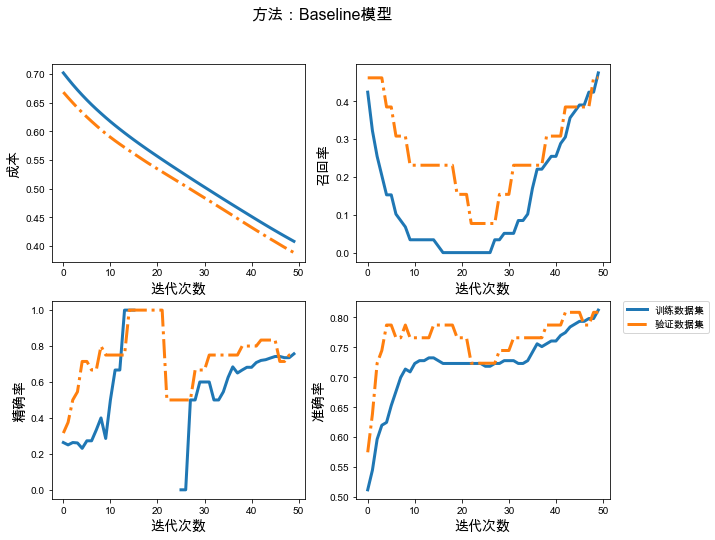

In [57]:
# 展示训练结果
plot_train_val(history_base, '方法：Baseline模型')

#### 7.1 样本添加权重

In [37]:
# 获取训练数据中各个类别的权重--字典格式
class_weight = {}
for cc in train['target'].unique():
    class_weight[cc] = len(train) / (len(train[train['target'] == cc]))
class_weight

{0: 1.3831168831168832, 1: 3.610169491525424}

In [38]:
# 保存模型的文件夹
checkpoint_path_weight = "./weight-{val_loss:.5f}.ckpt"
checkpoint_dir_weight = os.path.dirname(checkpoint_path_weight)

# 创建一个回调，保证验证数据集损失最小
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_weight, save_weights_only=True,
                                                    monitor='val_loss', mode='min', verbose=2, save_best_only=True)
# 模型训练
weight_model = build_model()
# 添加样本权重
history_weight = weight_model.fit(train_ds, validation_data=val_ds, epochs=50, class_weight=class_weight, callbacks=[model_callback])

Train for 1 steps, validate for 1 steps
Epoch 1/50

Epoch 00001: val_loss improved from inf to 1.45956, saving model to ./weight-1.45956.ckpt
1/1 [==============================] - 3s 3s/step - loss: 1.4172 - rr: 0.4068 - pr: 0.2963 - accuracy: 0.5681 - val_loss: 1.4596 - val_rr: 0.3846 - val_pr: 0.3125 - val_accuracy: 0.5957
Epoch 2/50

Epoch 00002: val_loss improved from 1.45956 to 1.43876, saving model to ./weight-1.43876.ckpt
1/1 [==============================] - 0s 204ms/step - loss: 1.3961 - rr: 0.4237 - pr: 0.2874 - accuracy: 0.5493 - val_loss: 1.4388 - val_rr: 0.4615 - val_pr: 0.3158 - val_accuracy: 0.5745
Epoch 3/50

Epoch 00003: val_loss improved from 1.43876 to 1.41893, saving model to ./weight-1.41893.ckpt
1/1 [==============================] - 0s 169ms/step - loss: 1.3762 - rr: 0.5254 - pr: 0.3407 - accuracy: 0.5869 - val_loss: 1.4189 - val_rr: 0.4615 - val_pr: 0.3158 - val_accuracy: 0.5745
Epoch 4/50

Epoch 00004: val_loss improved from 1.41893 to 1.39968, saving model t

In [39]:
# 加载已经训练好的参数
model_weight = build_model()
best_para_weight = tf.train.latest_checkpoint(checkpoint_dir_weight)
model_weight.load_weights(best_para_weight)

In [40]:
# 测试数据集的结果
y_test_weight = model_weight.predict(test_ds)
y_test_last_weight = tf.squeeze(tf.where(y_test_weight<0.5, x=0, y=1))

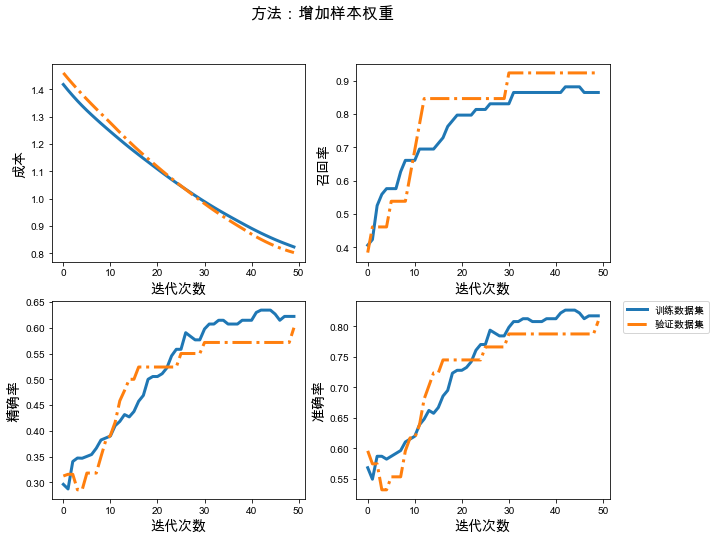

In [41]:
# 展示训练结果
plot_train_val(history_weight, '方法：增加样本权重')

#### 7.2 自定义成本函数：FocalLoss函数

自定义的函数除了利用继承相应的类实现以外，还可以直接写成下面函数的形式。如果为了加快运算，可以用tf.function()去修饰定义的函数。 

二分类模型的交叉熵成本函数，就是期望模型对类为0的样本的输出结果接近于0，对类为1的样本的输出结果接近1。下面是交叉熵成本函数：

$$Loss = -ylogy' - (1-y)log(1-y')$$

其中$y,y'$分别为所有样本的真实类别和模型对所有样本的输出值；

**FocalLoss**函数从两个方面进行了改进：

(1)考虑了样本难分和容易分的情况：例如在类为0的样本中，模型输出结果接近于0的就是容易分的样本，模型结果接近于1的是比较难分的样本。因此在计算成本时，就让难分的样本造成的成本占比相应的增大，容易分的造成的成本占比就适当的减小；注意这里的增大、减小，指的是占比，并不是数值。这部分是通过幂的形式来实现的，具体见下面的函数形式：

$$Fo\_Loss = -y(1-y')^{r}logy' - (1-y)y'^{r}log(1-y')$$

其中$r$取0时，上式就是交叉熵函数，推荐值$r=2$；

(2)对于样本不均衡的情况：每次训练，模型的成本很大一部分是由样本数较多的类别贡献的，这会使得模型偏向于这一类。因此要在计算成本时，要保证各种类别的成本对总成本的贡献度差不多。这部分的实现是通过为每一类的成本添加一个权重，也就是样本数少的，权重稍微大点。

$$Focall\_Loss = -(1-a)y(1-y')^{r}logy' - a(1-y)y'^{r}log(1-y')$$

In [42]:
# 下面给出类别标识为1的类是正类的FocalLoss函数:1类的权重为0.77， 0类的权重为0.23
@tf.function()
def anfany_FocalLoss(y_true, y_pred, name='FocalLoss', a=0.23, r=2): 
    loss_1 = - (1 - a) * tf.math.pow(1-y_pred, r) * tf.math.log(y_pred) * tf.cast(y_true, dtype=tf.float32)
    loss_0 = - a * tf.math.pow(y_pred, r) * tf.math.log(1-y_pred) * tf.cast((1 - y_true), dtype=tf.float32)
    return tf.add(loss_0, loss_1)

In [43]:
# 保存模型的文件夹
checkpoint_path_loss = "./loss-{val_loss:.5f}.ckpt"
checkpoint_dir_loss = os.path.dirname(checkpoint_path_loss)

# 创建一个回调，保证验证数据集损失最小
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_loss, save_weights_only=True,
                                                    monitor='val_loss', mode='min', verbose=2, save_best_only=True)

# 建立自定义成本函数的模型
loss_model = build_model(loss_func=anfany_FocalLoss)
# 模型训练
history_loss = loss_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[model_callback])

Train for 1 steps, validate for 1 steps
Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.07051, saving model to ./loss-0.07051.ckpt
1/1 [==============================] - 3s 3s/step - loss: 0.0738 - rr: 0.4746 - pr: 0.1892 - accuracy: 0.2911 - val_loss: 0.0705 - val_rr: 0.7692 - val_pr: 0.2500 - val_accuracy: 0.2979
Epoch 2/50

Epoch 00002: val_loss improved from 0.07051 to 0.06831, saving model to ./loss-0.06831.ckpt
1/1 [==============================] - 0s 156ms/step - loss: 0.0714 - rr: 0.5424 - pr: 0.2038 - accuracy: 0.2864 - val_loss: 0.0683 - val_rr: 0.7692 - val_pr: 0.2564 - val_accuracy: 0.3191
Epoch 3/50

Epoch 00003: val_loss improved from 0.06831 to 0.06638, saving model to ./loss-0.06638.ckpt
1/1 [==============================] - 0s 149ms/step - loss: 0.0693 - rr: 0.6610 - pr: 0.2281 - accuracy: 0.2864 - val_loss: 0.0664 - val_rr: 0.7692 - val_pr: 0.2500 - val_accuracy: 0.2979
Epoch 4/50

Epoch 00004: val_loss improved from 0.06638 to 0.06466, saving model to ./lo

In [44]:
# 加载已经训练好的参数
model_loss = build_model(loss_func=anfany_FocalLoss)
best_para_loss = tf.train.latest_checkpoint(checkpoint_dir_loss)
model_loss.load_weights(best_para_loss)

In [45]:
# 测试数据集的结果
y_test_loss = model_loss.predict(test_ds)
y_test_last_loss = tf.squeeze(tf.where(y_test_loss<0.5, x=0, y=1))

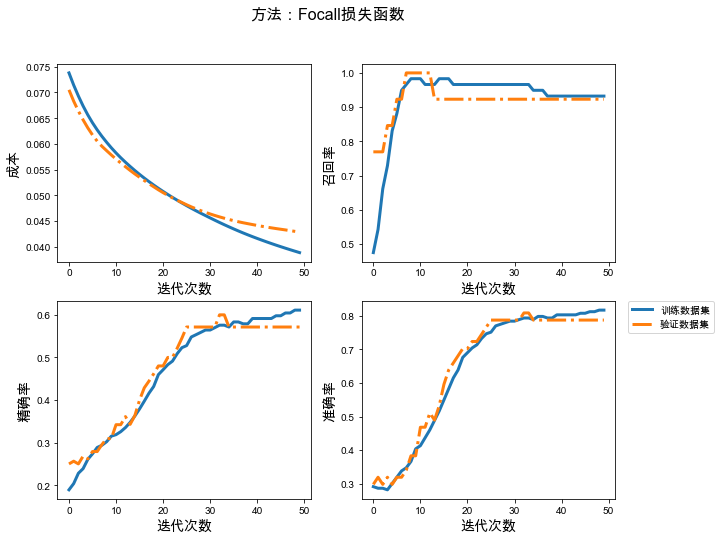

In [46]:
# 展示训练结果
plot_train_val(history_loss, '方法：Focall损失函数')

#### 7.3 重采样

利用重采样解决样本不均衡，就是对样本数较少的类别进行采样，从而增加该类别的样本数。也就是需要更改训练数据集train。

In [47]:
# 对数据集中样本较少的类别进行重采样，保证每个类别的样本数据相同
def resample_class(data, class_name='target'):
    unique_class = data[class_name].unique()
    count_dict = {}
    for k in unique_class:
        count_dict[k] = len(data[data[class_name] == k])
    # 各个类别中样本数的最大值
    max_count = sorted(count_dict.items(), key=lambda s:-s[1])[0][1]
    
    # 开始针对各个类别重采样
    for kk in count_dict:
        if count_dict[kk] != max_count:
            # 需要重采样的数
            need_count = max_count - count_dict[kk]
            # 采样范围
            all_data = data[data[class_name] == kk]
            # 采样得到的数据
            sample_data = all_data.sample(need_count, random_state=1, replace=True)
            # 需要和原来的数据结合
            data = pd.concat([sample_data, data], axis=0)
    return data

# 重新采样后的数据
train_re = resample_class(train)

In [48]:
print('训练数据 条数:%3d' % len(train_re), '其中%s' % (judge(train_re)))

训练数据 条数:308 其中1:154  0:154  


In [49]:
# 加入到数据管道中
batch_size = 300
train_ds_resample = df_to_dataset(train_re, batch_size=batch_size)

In [50]:
# 建立模型
# 保存模型的文件夹
checkpoint_path_resample = "./resample-{val_loss:.5f}.ckpt"
checkpoint_dir_resample = os.path.dirname(checkpoint_path_resample)

# 创建一个回调，保证验证数据集损失最小
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_resample, save_weights_only=True,
                                                    monitor='val_loss', mode='min', verbose=2, save_best_only=True)
# 模型训练
resample_model = build_model()
# 添加样本权重
history_resample = resample_model.fit(train_ds_resample, validation_data=val_ds, epochs=50, callbacks=[model_callback])

Train for 2 steps, validate for 1 steps
Epoch 1/50
1/2 [==============>...............] - ETA: 1s - loss: 0.7480 - rr: 0.9122 - pr: 0.4754 - accuracy: 0.4600
Epoch 00001: val_loss improved from inf to 0.80218, saving model to ./resample-0.80218.ckpt
2/2 [==============================] - 3s 1s/step - loss: 0.7240 - rr: 0.9091 - pr: 0.4811 - accuracy: 0.4643 - val_loss: 0.8022 - val_rr: 1.0000 - val_pr: 0.2889 - val_accuracy: 0.3191
Epoch 2/50
1/2 [==============>...............] - ETA: 0s - loss: 0.7318 - rr: 0.9281 - pr: 0.4965 - accuracy: 0.4833
Epoch 00002: val_loss improved from 0.80218 to 0.79119, saving model to ./resample-0.79119.ckpt
2/2 [==============================] - 0s 95ms/step - loss: 0.7667 - rr: 0.9286 - pr: 0.4864 - accuracy: 0.4740 - val_loss: 0.7912 - val_rr: 1.0000 - val_pr: 0.2889 - val_accuracy: 0.3191
Epoch 3/50
1/2 [==============>...............] - ETA: 0s - loss: 0.7253 - rr: 0.9400 - pr: 0.4913 - accuracy: 0.4833
Epoch 00003: val_loss improved from 0.79119 

In [51]:
# 加载已经训练好的参数
model_resample = build_model()
best_para_resample = tf.train.latest_checkpoint(checkpoint_dir_resample)
model_resample.load_weights(best_para_resample)

In [52]:
# 测试数据集的结果
y_test_resample = model_resample.predict(test_ds)
y_test_last_resample = tf.squeeze(tf.where(y_test_resample<0.5, x=0, y=1))

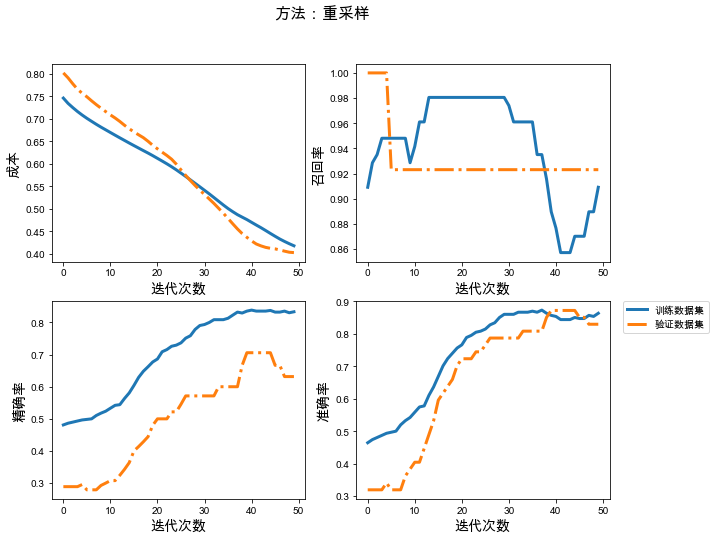

In [60]:
# 展示训练结果
plot_train_val(history_resample, '方法：重采样')

### 8、不同方法的结果对比

In [54]:
# 计算召回率Recall，精确率Precision，准确率Accuracy
def get_rate(labels, predictions, pasign=1): # 类为1的是正类
    # 获取混淆矩阵，
    matrix = tf.math.confusion_matrix(labels, predictions)
    # 召回率
    rr = [matrix[pasign, pasign].numpy(), tf.reduce_sum(matrix, 1)[pasign].numpy()]
    # 精确率
    pr =[matrix[pasign, pasign].numpy(), tf.reduce_sum(matrix, 0)[pasign].numpy()]
    # 准确率
    acc = [tf.reduce_sum(tf.cast(tf.equal(labels, predictions), dtype=tf.int32)).numpy() ,len(labels)]
    return matrix, rr, pr, acc

In [55]:
# 绘制混淆矩阵，输出召回率，精确率，以及准确率
def plot_cm_rate(labels, predictions, name, ax):
    # 计算
    matrix, rr, pr, acc = get_rate(labels, predictions)
    sns.heatmap(matrix, annot=True, fmt="d", cbar=False, ax=ax[0], linewidths=1, square='equal',
                linecolor='white', annot_kws={'fontsize':13}, xticklabels=['未患病', '患病'], yticklabels=['未患病', '患病'])
    ax[0].set_title('混淆矩阵', fontsize=13)
    ax[0].set_ylabel('实际类别', fontsize=13)
    ax[0].set_xlabel('预测类别', fontsize=13)
    ax[1].set_axis_off()
    ax[1].set_aspect('equal')
    for y, j, f in zip(np.linspace(0.7, 0.3, 3), [rr, pr, acc], ['召回率', '精确率', '准确率']):
        ax[1].text(0.0, y, r'%s：$%s/%s=%.4f$' % (f, j[0], j[1], j[0]/j[1]), fontsize=13)
    ax[0].text(1.9,-0.1, name, fontsize=15, color='red')
    return ax

<Figure size 432x288 with 0 Axes>

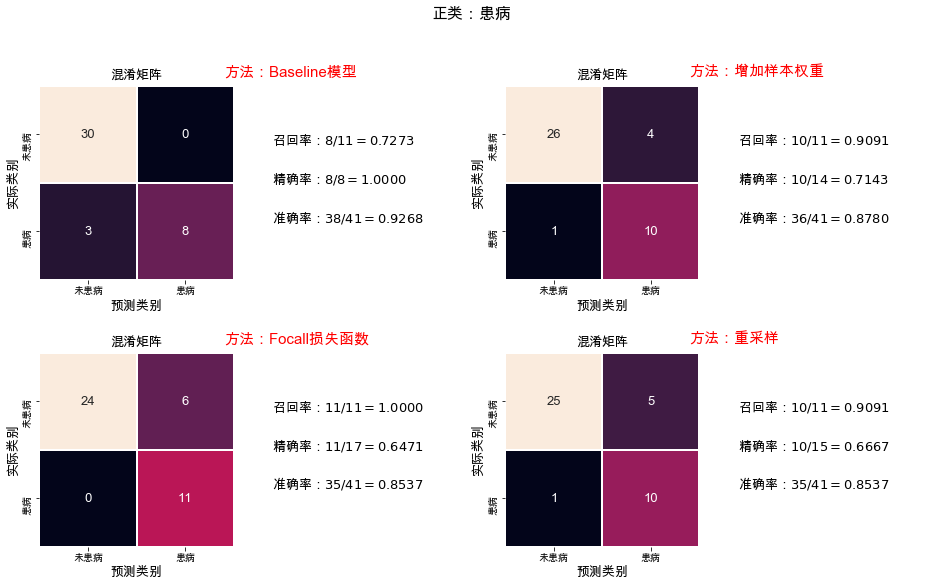

In [56]:
# 集成图片
def plot_method():
    fig = plt.figure()
    fig, ax = plt.subplots(2, 4, figsize=(16, 9))
    plot_cm_rate(test['target'].values, y_test_last_base, '方法：Baseline模型', ax[0, :2])
    plot_cm_rate(test['target'].values, y_test_last_weight, '方法：增加样本权重', ax[0, 2:])
    plot_cm_rate(test['target'].values, y_test_last_loss, '方法：Focall损失函数', ax[1, :2])
    plot_cm_rate(test['target'].values, y_test_last_resample, '方法：重采样', ax[1, 2:])
    plt.suptitle('正类：患病', fontsize=16)  
    fig.savefig('method.png', dpi=200, bbox_inches = 'tight')
plot_method()    